# Identify the Sentiments

## Problem Statement

Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material, and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. Brands can use this data to measure the success of their products in an objective manner. In this challenge, you are provided with tweet data to predict sentiment on electronic products of netizens.

## Data

**train.csv** - For training the models, we provide a labelled dataset of 7920 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

**test.csv** - The test data file contains only tweet ids and the tweet text with each tweet in a new line.

**sample_submission.csv** - The exact format for a valid submission

Most profane and vulgar terms in the tweets have been replaced with “$&@*#”. However, please note that the dataset still might contain text that may be considered profane, vulgar, or offensive.

## Solution

### Libraries 

In [58]:
# Standard libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

import string 
import warnings


pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Loading the data to dataframe

In [2]:
train_data = pd.read_csv('Datasets/offencivetweet/train.csv')
test_data = pd.read_csv('Datasets/offencivetweet/test.csv')

In [3]:
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


### Data Inspection

In [4]:
train_data['tweet'][777]

"Thank you but i don't need your good for nothing phone #welovesamsung"

In [5]:
# To display tweet that are not racist
train_data[train_data['label']== 0].head(10)

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/
7,8,0,New Type C charger cable #UK http://www.ebay.co.uk/itm/-/112598674021 … #bay #Amazon #etsy New Year #Rob Cross #Toby Young #EVEMUN #McMafia #Taylor #SPECTRE 2018 #NewYear #Starting 2018 #recipes #...
8,9,0,Bout to go shopping again listening to music #iphone #justme #music #likeforlike #followforfollow… http://instagr.am/p/Vj6bg5tLql/
9,10,0,Photo: #fun #selfie #pool #water #sony #camera #picoftheday #sun #instagood #boy #cute #outdoor... http://tmblr.co/ZAjC0n1ms_Gp8
13,14,0,"I just made another crazy purchase lol my theory is 'Work hard, Play Hard' Lol #iPad #Apple #Shopping http://instagr.am/p/NUyFHvyE7I/"
15,16,0,From #DeepEllum towards #downtown #Dallas. #BigD #Saturday #RX100M3 #Sony #summer #urban http://instagram.com/p/pzJoOaQqZ4/


In [6]:
# To display tweet that are racist

train_data[train_data['label'] == 1].head(5)

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
10,11,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,12,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,13,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo


In [7]:
train_data.shape, test_data.shape

((7920, 3), (1953, 2))

In [8]:
train_data.label.value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [9]:
train_data['tweet'][0]

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

### Data Cleaning 

The steps below to clean the raw tweets in out data.

1. Remove the twitter handles as they are already masked as @user due to privacy concerns. These twitter handles hardly give any information about the nature of the tweet.

2. Remove the links eg : 'https://goo.gl/h1MfQV' because they do not add much values.

3. Get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets.

4. Lastly, we will normalize the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information.And also remove stop words.

In [10]:
stop_words = set(stopwords.words('english')) 


def clean_data(tweet):
    """ Removes 
    1. Remove the twitter handles 

    2. Remove the links eg : 'https://goo.gl/h1MfQV' because they do not add much values.

    3. Get rid of the punctuations, numbers and even special characters 
    """
    return ' '.join(re.sub("http\S\S\S+| (@[A-Za-z0-9]+) |([^0-9A-Za-z \t])", " ", tweet.lower()).split())

def drop_data(features, data):
    """
    To remove the features which are not needed
    """
    data.drop(features, axis =1, inplace = True)
    
def stemSentence(row):
    """ In this fuction we normalize our text that is changing a word to its base.
        But before that we will have to tokenize the tweets. 
        Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.
        Stemming and Lemmatization both generate the root form of the inflected words. 
        The difference is that stem might not be an actual word whereas, lemma is an actual language word.
        Here we use lemmatization
        This function also removes 
    """
    lemmatizer = WordNetLemmatizer()
    sentence = row
    token_words=word_tokenize(sentence)
    stem_sentence=[]   
    filtered_sentence = [] 
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    for w in stem_sentence: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    
    return " ".join(filtered_sentence)          


In [11]:
train_data['processed_tweet'] = train_data['tweet'].apply(clean_data)

In [12]:
train_data.head()

,id,label,tweet,processed_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax iphone smartphone wifi connect
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i m wired i know i m george i was made that way iphone cute daventry home
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple won t even talk to me about a question i have unless i pay them 19 95 for their stupid support


In [13]:
train_data['final_processed_tweet'] = train_data['processed_tweet'].apply(stemSentence)

In [14]:
drop_data(['id', 'tweet','processed_tweet'], train_data)

In [15]:
train_data.head()

,label,final_processed_tweet
0,0,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,0,finally transparant silicon case thanks uncle yay sony xperia sonyexperias
2,0,love would go talk makememories unplug relax iphone smartphone wifi connect
3,0,wired know george wa made way iphone cute daventry home
4,1,amazing service apple even talk question unless pay 19 95 stupid support


### Visualization from Tweets

To explore the cleaned tweets:
    
    1. What are the common words in the set
    2. Most common word in racist and non racist tweet

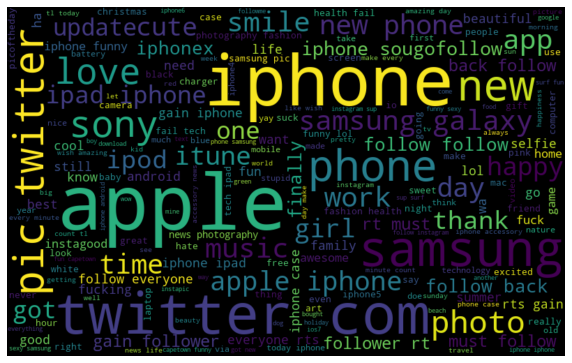

In [16]:
# 1. What are the common words in the dataset

all_words = ' '.join([text for text in train_data['final_processed_tweet']]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

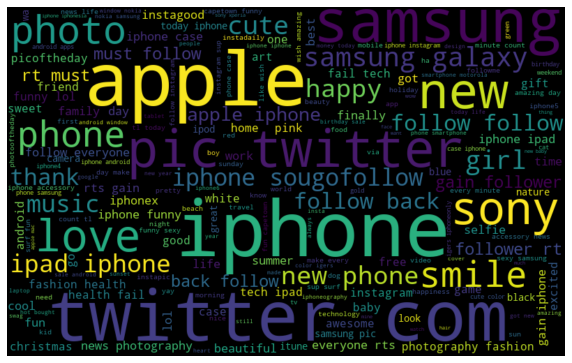

In [17]:
# 2.1 Find the most common word in not racist tweets

normal_words =' '.join([text for text in train_data['final_processed_tweet'][train_data['label'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()


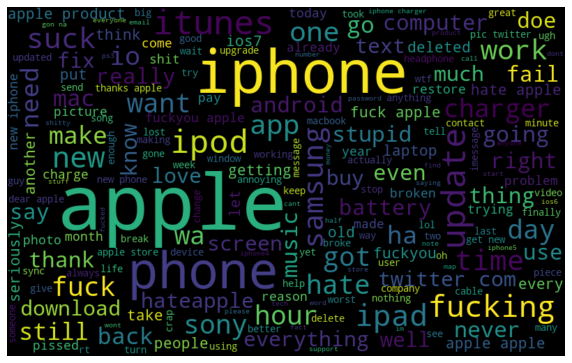

In [18]:
# 2.2 Find the most common word in racist tweets

normal_words =' '.join([text for text in train_data['final_processed_tweet'][train_data['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()


### Feature extraction 

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques 
* Bag of Words
* TF-IDF
* Word Embeddings.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(train_data["final_processed_tweet"],train_data["label"], test_size = 0.2, random_state = 42)

In [48]:
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [49]:
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [50]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(6336, 14482)
(6336, 14482)


In [51]:
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [52]:
print(x_test_counts.shape)
print(x_test_tfidf.shape)

(1584, 14482)
(1584, 14482)


### Modelling

In [57]:
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
model.score(x_test_tfidf, y_test)

0.8718434343434344

### Hypertune the model 

In [70]:
parameters = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

In [71]:
gs_clf = GridSearchCV(model, param_grid=parameters, cv= 5, n_jobs=-1)
gs_clf = gs_clf.fit(x_train_tfidf,y_train)

In [72]:
gs_clf.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [73]:
gs_clf.best_score_

0.748421717014533

### Preparing test data

In [75]:
test_data['processed_tweet'] = test_data['tweet'].apply(clean_data)
test_data['final_processed_tweet'] = test_data['processed_tweet'].apply(stemSentence)
drop_data(['tweet','processed_tweet'], test_data)

In [76]:
test_data.head()

,id,final_processed_tweet
0,7921,hate new iphone upgrade let download apps ugh apple suck
1,7922,currently shitting fucking pant apple imac cashmoney raddest swagswagswag
2,7923,like put cd rom ipad possible yes block screen
3,7924,ipod officially dead lost picture video 1d 5sos concert vet camp hatinglife sobbing
4,7925,fighting itunes night want music paid
